# Temporal Coarse-Graining and Exact Inference

## In this Jupyter notebook, I simulate inference on a boltzmann machine through TAP and mean-field message passing
## I then coarse-grain the data temporally, averaging over the latent state probabilities between neighboring timepoints with a low-pass filter
## Finally, the coarse-grain data is used to infer the underlying message-passing algorithm. The message-update coefficients G and latent state probabilities x form a system of linear equations, allowing G to be estimated in closed form.

In [1]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
import builtins
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/its/home/cg610/coarse_graining_algorithms/coarse_graining_algorithms/notebooks/../code/particlefilter.py'>

### First let's simulate latent state dynamics under both mean-field and TAP update equations

In [2]:
import numpy as np
np.random.seed(13)
# Do exact inference when data are constrained by number of nodes
# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 16,2,16
Ns, Nr, Ny = 441,2,441

B_train = 1       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 16                         # No. of time steps 
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
# T_low, T_high = 2, 5          # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
#yG_low, yG_high = 2, 3   # 

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1
#J = J*.5  # scale down for stability
#J = array([[0,.8,-.4],[.8,0,.2],[-.4,.2,0]])  # No state dependence
#J = np.full((Ns, Ns), 0.05)
#np.fill_diagonal(J, 0)

# Connectivity matrix between state and observation nodes
# Ns x Ny
if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V = array([[-1,1,1],[1,-1,-1],[1,1,-1]])*3.5
V = np.zeros((Ns,Ny))  # No input dependence
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta_TAP = np.concatenate([lam, G_TAP, JMatToVec(J), U.flatten('F'), V.flatten('F') ])
theta_MF = np.concatenate([lam, G_MF, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

batches = 1
##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
input = generate_input_binary(B_train, Ny, T-1)
initial_x = np.random.rand(Ns,B_train) 	
y_train_TAP, x_train_TAP, r_train_TAP = tap.generate_TAPdynamics(theta_TAP, params, batches, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)
y_train_MF, x_train_MF, r_train_MF = tap.generate_TAPdynamics(theta_MF, params, batches, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)

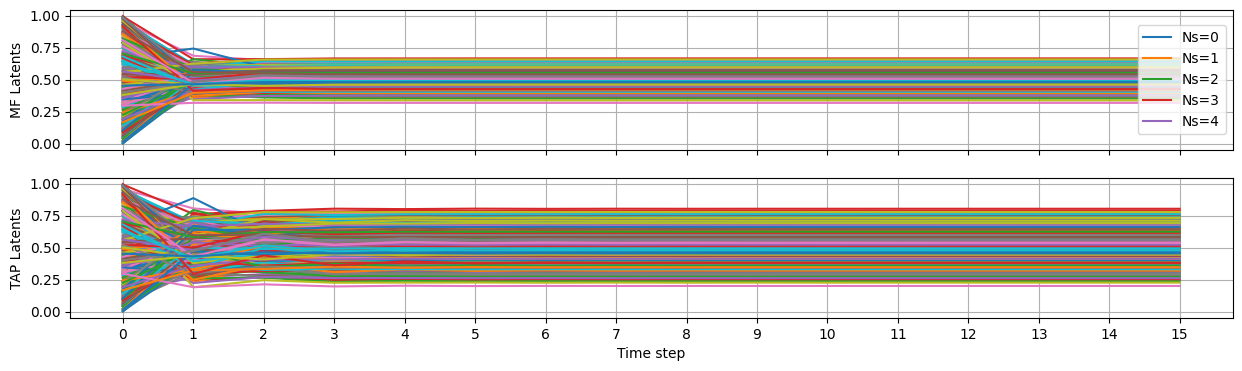

In [3]:
# Plot MF and TAP latent updates
B_to_plot = 2 
B_total, Ns, T = x_train_TAP.shape
max_plot_time = 20

fig, axs = plt.subplots(B_to_plot, 1, figsize=(15, 2*B_to_plot), sharex=True)

# Plot MF latents
for n in range(Ns):
    axs[0].plot(x_train_MF[0, n, :max_plot_time], label=f'Ns={n}' if n<5 else None)
axs[0].set_ylabel(f'MF Latents')
axs[0].grid(True)

# Plot TAP latents
for n in range(Ns):
    axs[1].plot(x_train_TAP[0, n, :max_plot_time], label=f'Ns={n}')
axs[1].set_ylabel(f'TAP Latents')
axs[1].grid(True)
axs[-1].set_xticks(range(T))

axs[-1].set_xlabel('Time step')
axs[0].legend(loc='right')  # show legend only on first plot
plt.show()


### Validate analytic parameter estimation by recovering true parameters for both MF and TAP


In [5]:
# Validate parameter recovery for one time point and all timepoints
# MF
if Ns == 18:
    G_coarse_inferred_T0_TAP = tap.infer_exact_G_first_timepoint(y_train_TAP, x_train_TAP, params,theta_TAP)
    G_coarse_inferred_T0 = tap.infer_exact_G_first_timepoint(y_train_MF, x_train_MF, params,theta_MF)
    
G_coarse_inferred_all = tap.infer_exact_G_all_timepoints(y_train_MF, x_train_MF, params,theta_MF) 
# TAP
G_coarse_inferred_all_TAP = tap.infer_exact_G_all_timepoints(y_train_TAP, x_train_TAP, params,theta_TAP)

### Here we use a jumping window whose stride is equal to the window size, so it does not act as a loss-pass filter

In [5]:
# Average y and x
# reshape so the last dimension becomes (num_groups, window_avg)
window_avg = 4
x_arr_grouped = x_train_MF.reshape(B_train, Ns, T // window_avg, window_avg)
# average over each group
x_arr_avg = x_arr_grouped.mean(axis=-1)

# # Reshape y_train
# # first, trim y_train so its time dimension is divisible by window_avg
num_obs_reshaped = y_train_MF.shape[2] // window_avg
y_train_trimmed = y_train_MF[:, : , -num_obs_reshaped * window_avg:]
# reshape so the last dimension becomes (num_groups, window_avg)
y_arr_grouped = y_train_trimmed.reshape(B_train, Ny, num_obs_reshaped, window_avg)
# average over each group
y_arr_avg = y_arr_grouped.mean(axis=-1)
G_coarse_inferred_T0 = tap.infer_exact_G_all_timepoints(y_arr_avg, x_arr_avg, params,theta_MF)


### Estimate G for different lengths of a jumping window for mean-field.
#### Here, we find that greater window sizes cause the higher-order terms in G to get really big.

In [28]:
import numpy as np

def divisors(n):
    """Return all positive divisors of n sorted."""
    return sorted([d for d in range(1, n+1) if n % d == 0])

T = x_train_MF.shape[2]
window_list = divisors(T)

G_results = {}   # dictionary: key = window_avg, value = G_coarse_inferred

for window_avg in window_list[:-1]:
    # --- X ---
    x_arr_grouped = x_train_MF.reshape(B_train, Ns, T // window_avg, window_avg)
    x_arr_avg = x_arr_grouped.mean(axis=-1)

    # --- Y ---
    num_obs_reshaped = y_train_MF.shape[2] // window_avg
    y_train_trimmed = y_train_MF[:, :, -num_obs_reshaped * window_avg:]
    y_arr_grouped = y_train_trimmed.reshape(B_train, Ny, num_obs_reshaped, window_avg)
    y_arr_avg = y_arr_grouped.mean(axis=-1)

    # --- Inference ---
    G_coarse_inferred = tap.infer_exact_G_all_timepoints(y_arr_avg, x_arr_avg, params, theta_MF)

    # --- Save result ---
    G_results[window_avg] = G_coarse_inferred

# Optional: print what you collected
for w, Gval in G_results.items():
    print(f"window_avg = {w}: G = {Gval}")


window_avg = 1: G = (array([-2.49369237e-15,  1.00000000e+00, -1.29387536e-14,  1.30176315e-14,
       -5.34384251e-14,  5.67400434e-14, -1.47365482e-14,  5.65640552e-14,
       -6.04614883e-14,  1.91145297e-15, -3.06633792e-15,  1.79440223e-15,
       -6.54151398e-15,  2.57199694e-14, -2.71031871e-14,  6.77702562e-15,
       -3.24070016e-14,  4.18727553e-14]), {'residuals': 7.903483820359081e-30, 'Phi_shape': (240, 18), 'y_shape': (240,)})
window_avg = 2: G = (array([ -15.86640557,   62.36506209,  -59.12412272,   60.20445582,
       -233.0467005 ,  225.39155921,  -55.35187597,  215.33336728,
       -210.2399074 ,  -49.79026571,  146.97836023,  -94.84963422,
        167.18217542, -460.64248309,  253.25923743, -129.36300251,
        313.76007538, -110.61684485]), {'residuals': 0.009986524432952136, 'Phi_shape': (112, 18), 'y_shape': (112,)})
window_avg = 4: G = (array([  -37.97791251,   150.18702934,  -146.23922093,   151.98188488,
        -600.053336  ,   589.6240194 ,  -151.25369825, 

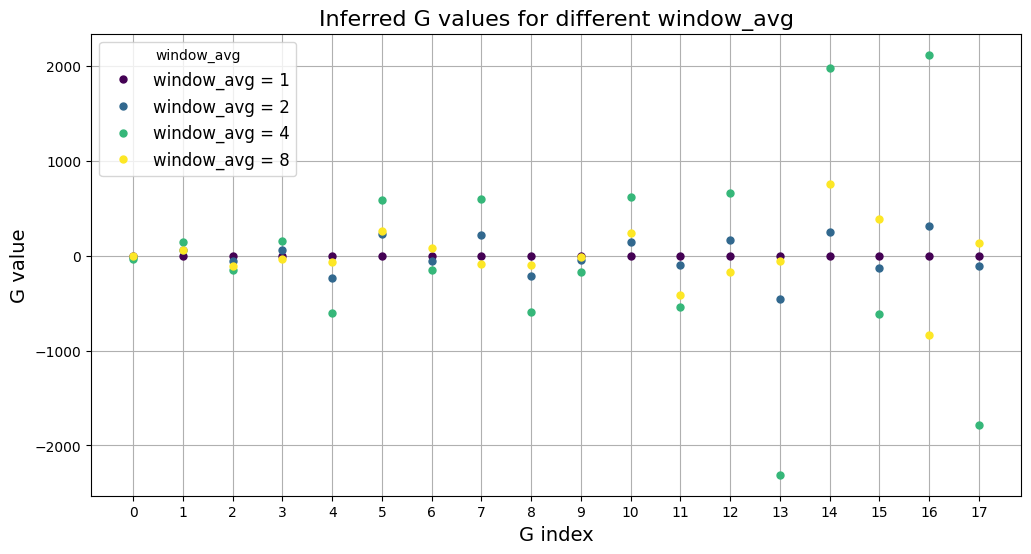

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get sorted window sizes
window_list = sorted(G_results.keys())

# Assume all G vectors have same length
G_length = len(G_results[1][0])
x = np.arange(G_length)

# Colormap
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(window_list)))

plt.figure(figsize=(12, 6))

# Plot each G vector
for color, w in zip(colors, window_list):
    G_vec = G_results[w]
    plt.plot(x, G_vec[0], '.', color=color, markersize=10, label=f"window_avg = {w}")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("Inferred G values for different window_avg", fontsize=16)
plt.grid(True)
plt.legend(title="window_avg", fontsize=12)
plt.xticks(x)   # show each G index on the x-axis

plt.show()


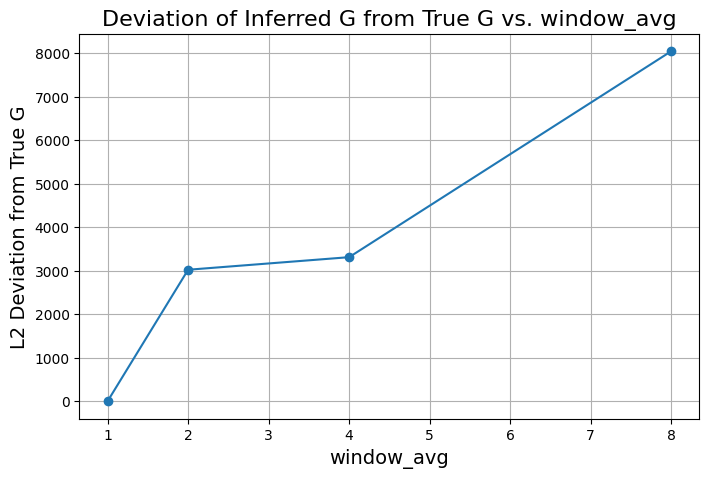

In [8]:
# Plot window_avg by deviations from true G
true_G = G_MF
deviations = []
window_sizes = []
for w, Gval in G_results.items():
    estimated_G = Gval[0]
    deviation = np.linalg.norm(estimated_G - true_G, ord=2)
    deviations.append(deviation)
    window_sizes.append(w)

plt.figure(figsize=(8,5))
plt.plot(window_sizes, deviations, 'o-')
plt.xlabel("window_avg", fontsize=14)
plt.ylabel("L2 Deviation from True G", fontsize=14)
plt.title("Deviation of Inferred G from True G vs. window_avg", fontsize=16)
plt.grid(True)
plt.show()

#### Next we do this for many combinations of kernel and stride

In [6]:
import numpy as np

def convolve(x_train, kernel, stride):
    B, Ns, T = x_train.shape
    start = 0
    end = kernel
    while start < T:
        if end > T:
            end = T
        x_segment = x_train[:, :, start:end]
        x_avg = x_segment.mean(axis=-1, keepdims=True)
        if start == 0:
            x_smooth = x_avg
        else:
            x_smooth = np.concatenate((x_smooth, x_avg), axis=-1)
        start += stride
        end += stride
    return x_smooth

kernel_list = range(1, int(T/2 + 1))  # Example kernel sizes 
stride_list = range(1, int(T/4 + 1)) # Most possible strides
# stride_list = [1,2,4,8]

def estimate_G_for_convolved_data(x_train, y_train, params, theta, kernel_list, stride_list):
    G_results = {}   # dictionary: key = window_avg, value = G_coarse_inferred

    for kernel in kernel_list:
        for stride in stride_list:
            # --- X ---
            x_smooth = convolve(x_train, kernel=kernel, stride=stride)

            # --- Y ---
            y_smooth = convolve(y_train, kernel=kernel, stride=stride)

            # --- Inference ---
            G_coarse_inferred = tap.infer_exact_G_all_timepoints(y_smooth, x_smooth, params, theta)
            # --- Save result ---
            G_results[(kernel, stride)] = G_coarse_inferred
    # Optional: print what you collected
    for (kernel,stride), Gval in G_results.items():
        print(f"Kernel = {kernel}, Stride = {stride}: G = {Gval}")
    return G_results

G_results_MF = estimate_G_for_convolved_data(x_train_MF, y_train_MF, params, theta_MF, kernel_list, stride_list)
G_results_TAP = estimate_G_for_convolved_data(x_train_TAP, y_train_TAP, params, theta_TAP, kernel_list, stride_list)

Kernel = 1, Stride = 1: G = (array([-2.49369237e-15,  1.00000000e+00, -1.29387536e-14,  1.30176315e-14,
       -5.34384251e-14,  5.67400434e-14, -1.47365482e-14,  5.65640552e-14,
       -6.04614883e-14,  1.91145297e-15, -3.06633792e-15,  1.79440223e-15,
       -6.54151398e-15,  2.57199694e-14, -2.71031871e-14,  6.77702562e-15,
       -3.24070016e-14,  4.18727553e-14]), {'residuals': 7.903483820359081e-30, 'Phi_shape': (240, 18), 'y_shape': (240,)})
Kernel = 1, Stride = 2: G = (array([ -0.54073305,   4.00466665,  -4.14752426,   3.31690986,
       -16.74876645,  21.66484388,  -2.98894521,  16.12023485,
       -22.08338596,  -3.29440502,   5.87353753,  -0.09288046,
        11.0073393 , -12.55856062, -13.57492892,  -7.03857736,
        -4.78528811,  33.60514531]), {'residuals': 0.011342369110060183, 'Phi_shape': (112, 18), 'y_shape': (112,)})
Kernel = 1, Stride = 3: G = (array([-5.01300343e-01,  4.11872773e+00, -4.25925979e+00,  2.92524276e+00,
       -1.58993929e+01,  2.04950537e+01, -2.4

#### Plot deviation from true G as a function of kernel and stride for both mean-field and TAP

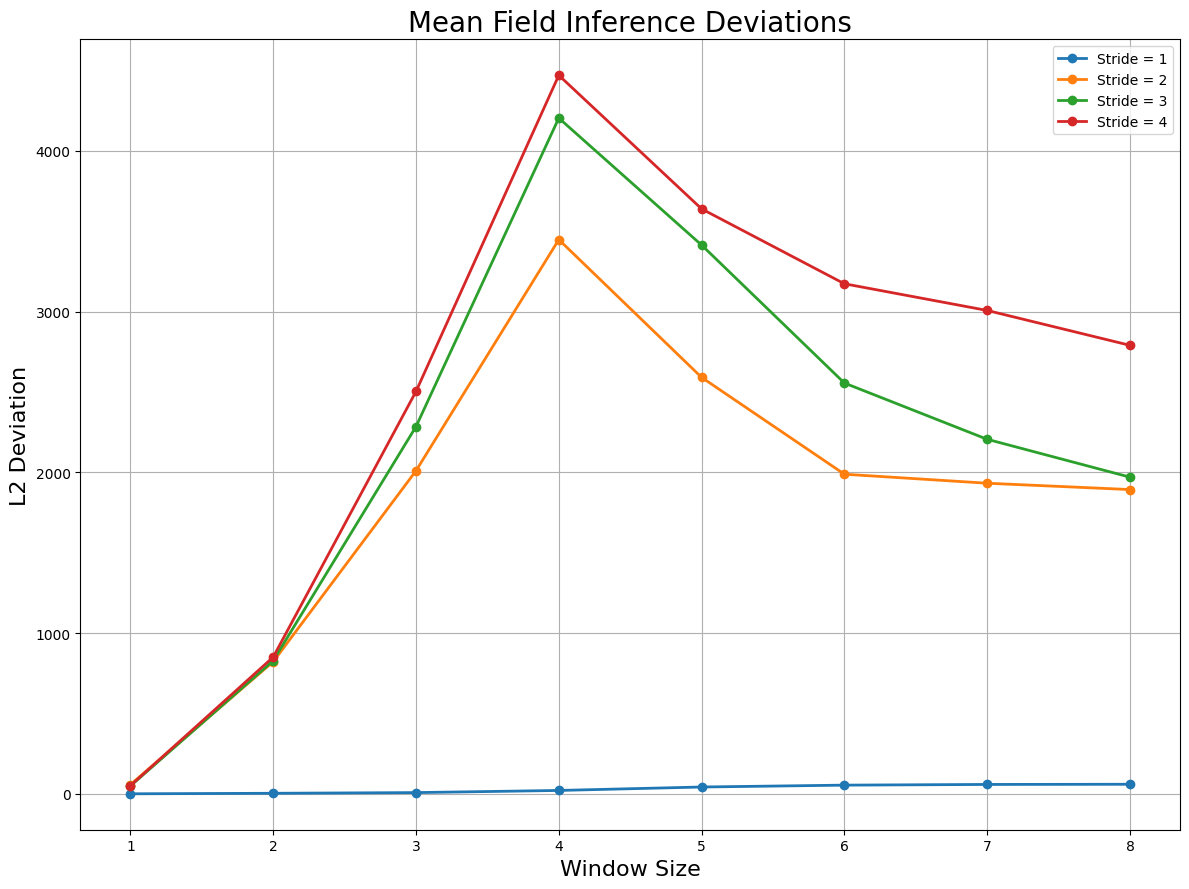

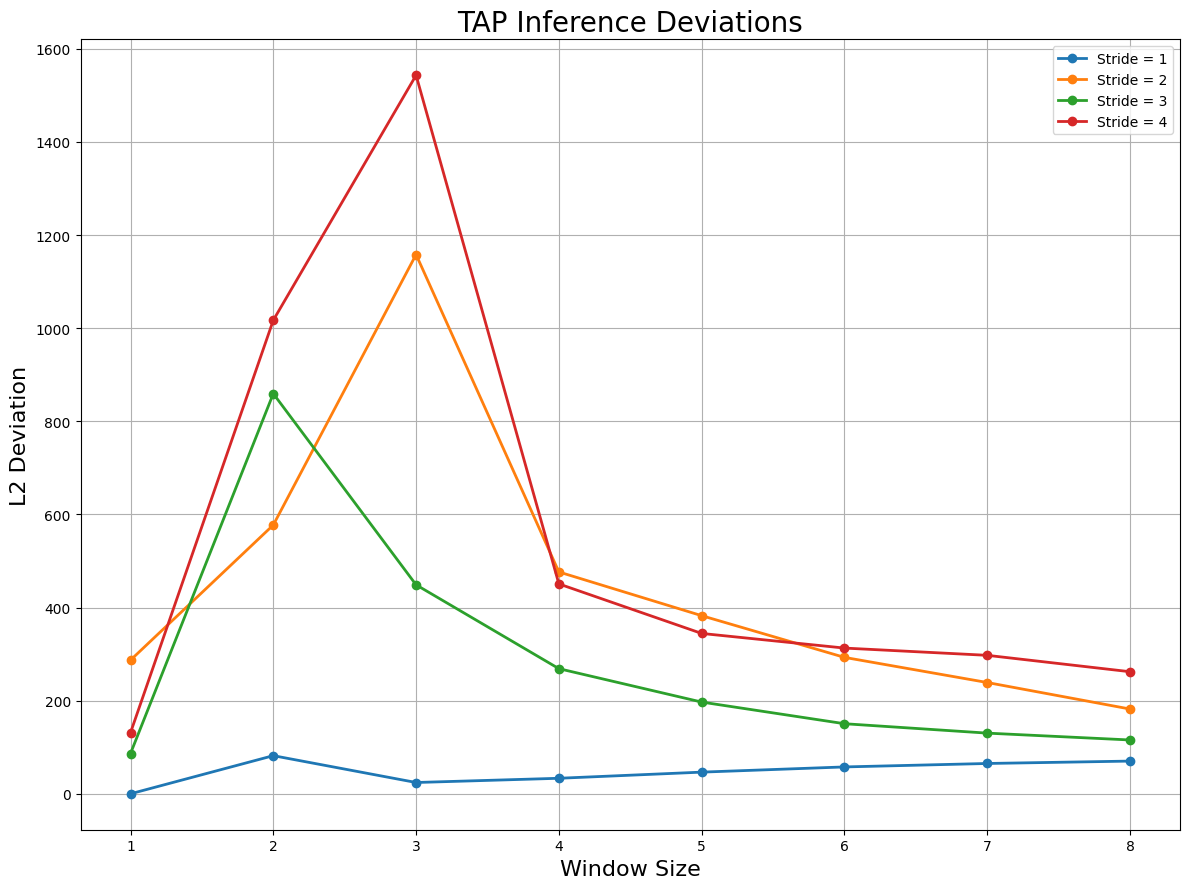

In [9]:
def plot_deviation_all_strides(G_results, true_G, title=""):
    kernels = sorted(set(k for (k, s) in G_results.keys()))
    strides = sorted(set(s for (k, s) in G_results.keys()))

    plt.figure(figsize=(12, 9))

    for stride in strides:
        deviations = []
        window_sizes = []

        for kernel in kernels:
            key = (kernel, stride)
            if key in G_results:
                Gval = G_results[key]
                dev = np.linalg.norm(Gval[0] - true_G, ord=2)
                deviations.append(dev)
                window_sizes.append(kernel)

        plt.plot(window_sizes, deviations, 'o-', linewidth=2, markersize=6, label=f"Stride = {stride}")

    plt.xlabel("Window Size", fontsize=16)
    plt.ylabel("L2 Deviation", fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_deviation_all_strides(G_results_MF,  G_MF,  title="Mean Field Inference Deviations")
plot_deviation_all_strides(G_results_TAP, G_TAP, title="TAP Inference Deviations")


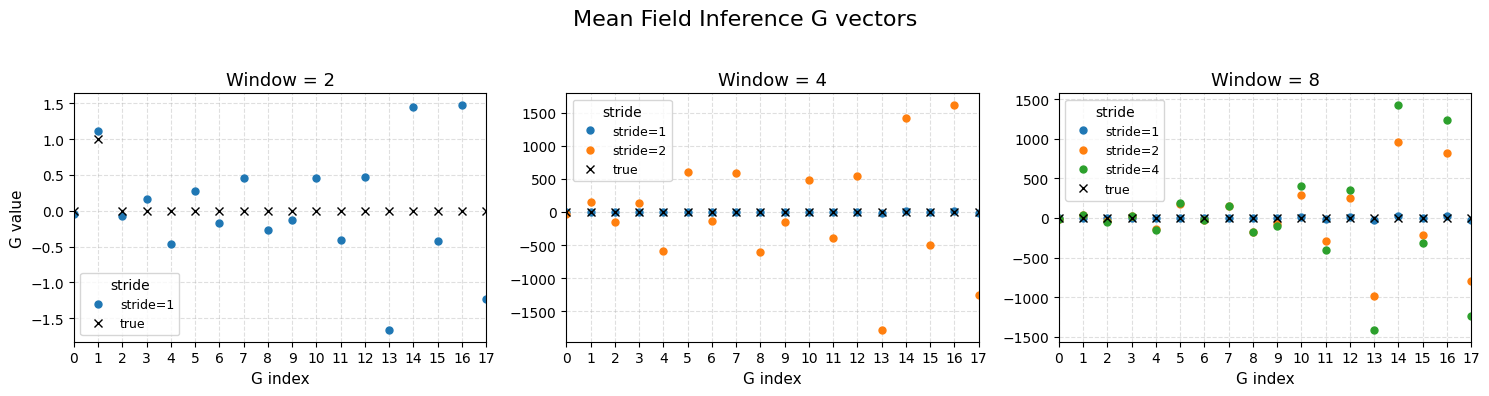

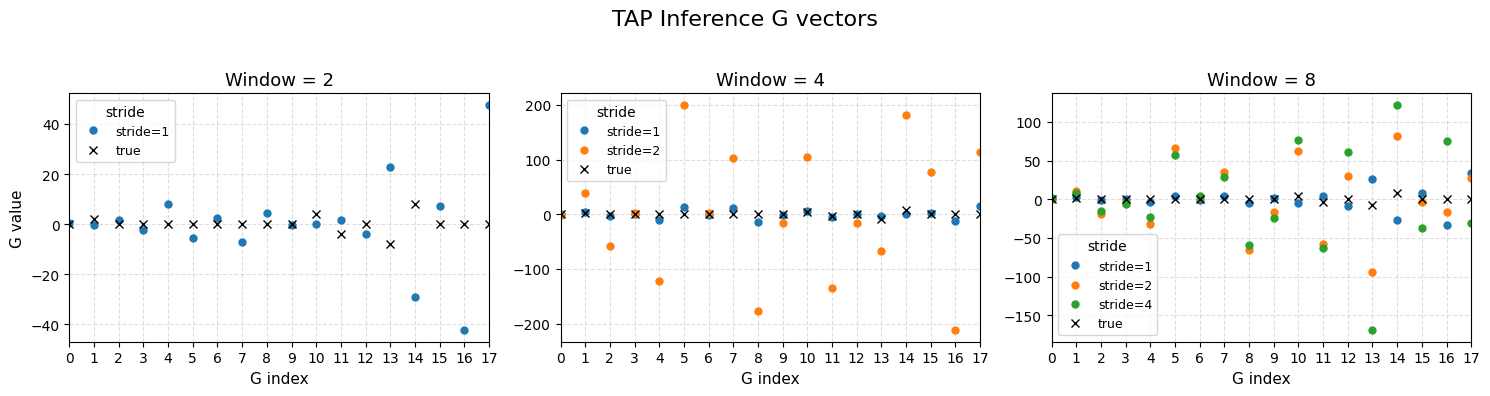

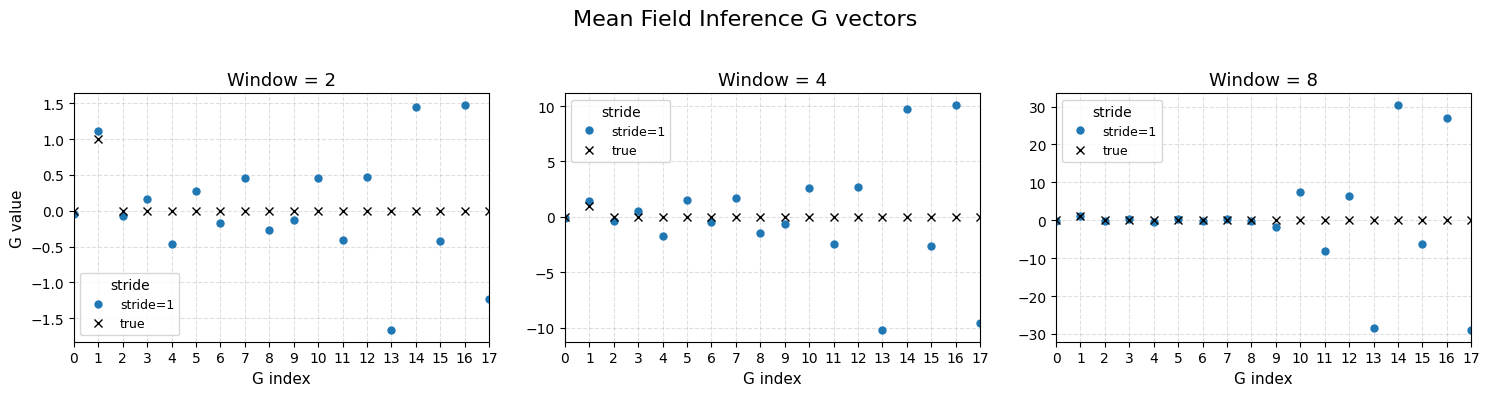

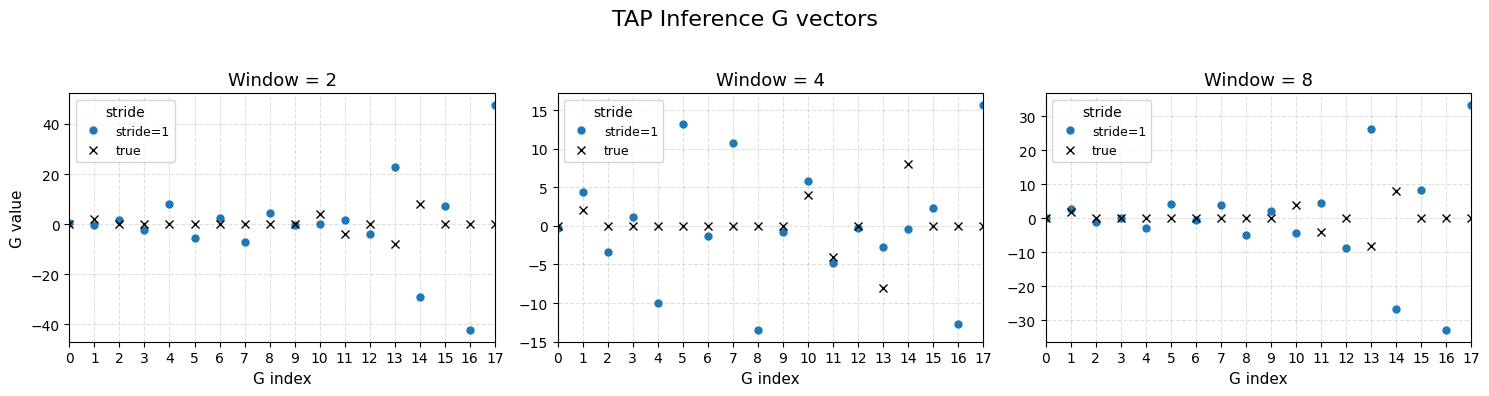

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

def _safe_extract_G(G_entry):
    """
    Return a 1D numpy array for the G vector or None if the entry is invalid.
    Handles:
      - numpy array
      - list/tuple where first element is the array (e.g., (array, meta))
      - None, scalar, empty tuple -> returns None
    """
    if G_entry is None:
        return None

    # If tuple/list, assume the first element is the array-like G
    if isinstance(G_entry, (list, tuple)):
        if len(G_entry) == 0:
            return None
        candidate = G_entry[0]
    else:
        candidate = G_entry

    # Convert to numpy array
    try:
        arr = np.asarray(candidate)
    except Exception:
        return None

    # Reject scalars / zero-dim / empty arrays
    if arr.ndim == 0 or arr.size == 0:
        return None

    return arr.ravel()


def plot_G_by_window_stride(G_results, window_stride_list,true_G_key=(1,1),
                            figsize_per_plot=(5,4), cmap_name="viridis",
                            marker="o", linestyle='', markersize=5,
                            xtick_every=1, title="Inferred G vectors by window and stride"):
    """
    Plot inferred G vectors grouped by window size. Each subplot is one window (kernel)
    and shows G vectors for the requested strides.

    Parameters
    ----------
    G_results : dict
        Keys: (kernel, stride), Values: numpy array G or (G_array, meta)
    window_stride_list : list of tuples
        Each element: (window, strides), where 'strides' is an iterable of ints
        Example: [(2, (1,)), (4, (1,2,3)), (8, (1,2,4,8))]
    figsize_per_plot : tuple
        (width, height) for each subplot
    cmap_name : str
        matplotlib colormap name for coloring different strides within a subplot
    marker, linestyle, markersize : plotting style
    xtick_every : int
        spacing for x ticks (1 means show every index)
    title : str
    """
    n_plots = len(window_stride_list)
    if n_plots == 0:
        raise ValueError("window_stride_list must contain at least one (window,strides) pair.")

    fig_w = figsize_per_plot[0] * n_plots
    fig_h = figsize_per_plot[1]
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.flatten()

    # extract true G for reference (if available)
    true_G = None
    if true_G_key in G_results:
        true_G = _safe_extract_G(G_results[true_G_key])


    for ax_idx, (window, strides) in enumerate(window_stride_list):
        ax = axes[ax_idx]
        # normalize strides to iterable
        if not isinstance(strides, (list, tuple, np.ndarray)):
            strides = (strides,)

        # --- Force stride=1 to be first (canonical blue) ---
        strides = list(strides)
        if 1 in strides:
            strides = [1] + [s for s in strides if s != 1]

        cmap = plt.get_cmap(cmap_name)
        colors = cmap(np.linspace(0, 1, builtins.max(1, len(strides))))


        # Track max G length for axis formatting
        max_len = 0
        plotted_any = False

        for color, stride in zip(colors, strides):
            key = (window, stride)
            if key not in G_results:
                warnings.warn(f"Missing key {key} in G_results — skipping.", UserWarning)
                continue

            G_vec = _safe_extract_G(G_results[key])
            if G_vec is None:
                warnings.warn(f"Invalid/empty G at key {key} — skipping.", UserWarning)
                continue

            x = np.arange(len(G_vec))
            ax.plot(x, G_vec, marker=marker, linestyle=linestyle,
                    markersize=markersize,label=f"stride={stride}")
            max_len = builtins.max(max_len, len(G_vec))
            plotted_any = True

        # --- Plot true G coefficients (if available) ---
        if true_G is not None:
            x_true = np.arange(len(true_G))
            ax.plot(
                x_true, true_G,
                marker="x", linestyle='', color="black",
                markersize=6, label="true"
            )
            max_len = builtins.max(max_len, len(true_G))
            plotted_any = True


        if not plotted_any:
            ax.text(0.5, 0.5, "No valid strides found", ha="center", va="center")
            ax.set_title(f"Window = {window}")
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Formatting
        ax.set_title(f"Window = {window}", fontsize=13)
        ax.set_xlabel("G index", fontsize=11)
        if ax_idx == 0:
            ax.set_ylabel("G value", fontsize=11)

        # set xticks
        xticks = np.arange(0, max_len, builtins.max(1, xtick_every))
        ax.set_xticks(xticks)
        ax.set_xlim(0, builtins.max(0, max_len-1))
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(title="stride", fontsize=9, title_fontsize=10, loc='best')

    # Hide extra axes if any
    for j in range(n_plots, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return fig, axes

# ------------------------------
# Example usage:
# ------------------------------
groups = [(2, (1,)), (4, (1,2)), (8, (1,2,4))]
fig, axes = plot_G_by_window_stride(G_results_MF, groups,title="Mean Field Inference G vectors")
fig, axes = plot_G_by_window_stride(G_results_TAP, groups,title="TAP Inference G vectors")

groups = [(2, (1,)), (4, (1,)), (8, (1,))]
fig, axes = plot_G_by_window_stride(G_results_MF, groups,title="Mean Field Inference G vectors")
fig, axes = plot_G_by_window_stride(G_results_TAP, groups,title="TAP Inference G vectors")


In [35]:
# Examine L2 norm deviations for TAP and MF for the best window and stride
window=2
stride = 1
G_coarse_inferred_TAP = G_results_TAP.get((window, stride), None)
G_coarse_inferred_MF = G_results_MF.get((window, stride), None)

# Calculate L2 deviations
deviation_TAP = np.linalg.norm(G_coarse_inferred_TAP[0] - G_TAP, ord=2) if G_coarse_inferred_TAP is not None else None
deviation_MF = np.linalg.norm(G_coarse_inferred_MF[0] - G_MF, ord=2) if G_coarse_inferred_MF is not None else None
print("hi")


hi


# Simulate neural activity based on neural sampling code

In [18]:
import numpy as np
# Do exact inference when data are constrained by number of nodes
# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 18,2,18

B_train = 1       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 10                         # No. of time steps 
kernel  = 30                     # Sliding window
stride = 5                       # how big each jump is
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
# T_low, T_high = 2, 5          # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
#yG_low, yG_high = 2, 3   # 

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1
#J = J*.5  # scale down for stability
#J = array([[0,.8,-.4],[.8,0,.2],[-.4,.2,0]])  # No state dependence
#J = np.full((Ns, Ns), 0.05)
#np.fill_diagonal(J, 0)

# Connectivity matrix between state and observation nodes
# Ns x Ny
if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V = array([[-1,1,1],[1,-1,-1],[1,1,-1]])*3.5
V = np.zeros((Ns,Ny))  # No input dependence
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta_TAP = np.concatenate([lam, G_TAP, JMatToVec(J), U.flatten('F'), V.flatten('F') ])
theta_MF = np.concatenate([lam, G_MF, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

batches = 1
##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
input = generate_input_binary(B_train, Ny, T-1)
initial_x = np.random.rand(Ns,B_train) 	
y_train_TAP, x_train_TAP, r_train_TAP = tap.generate_TAPdynamics(theta_TAP, params, batches, T, T_low, T_high, yG_low, yG_high,kernel,stride,input,initial_x,TAP_func=TAP_func)
y_train_MF, x_train_MF, r_train_MF = tap.generate_TAPdynamics(theta_MF, params, batches, T, T_low, T_high, yG_low, yG_high,kernel,stride,input,initial_x,TAP_func=TAP_func)

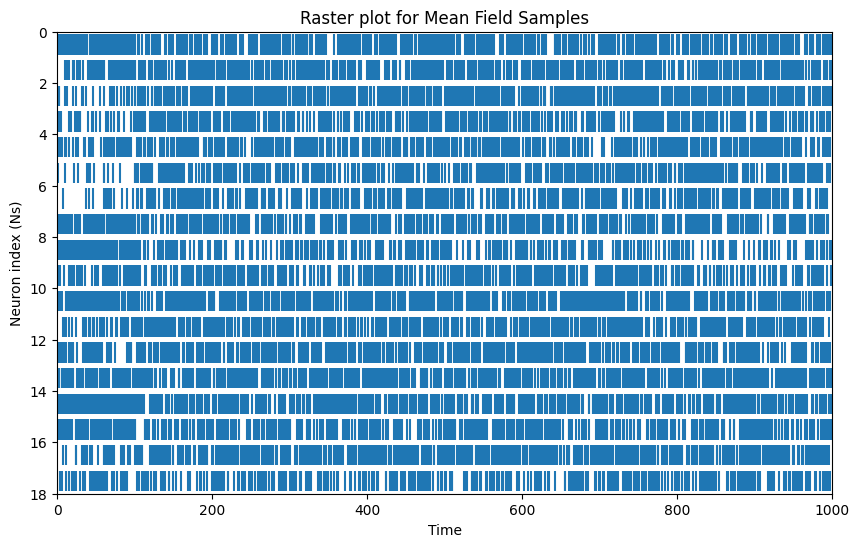

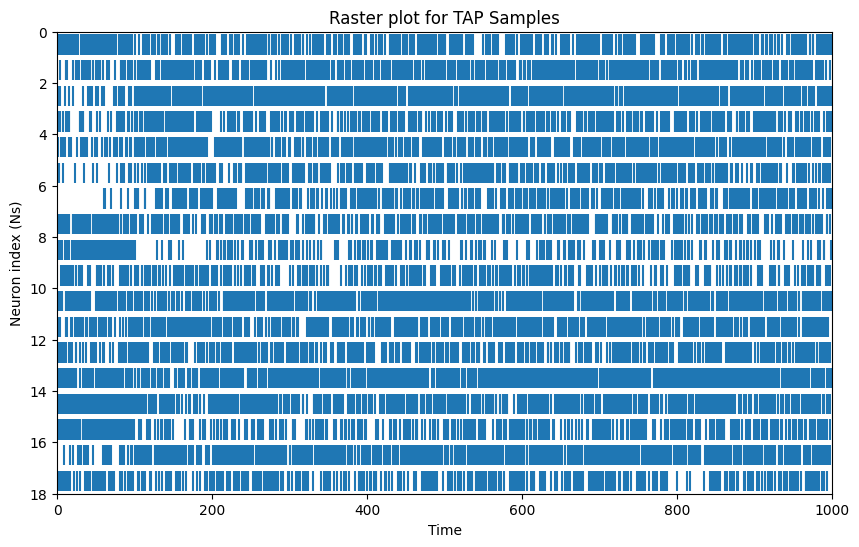

In [19]:
# Turn both MF and TAP message passing into neural activations (assuming a neural sampling code!!!!)
samples_per_timestep = 100
# Step 1: expand probs to (B, Ns, T, samples_per_timestep)
expanded_MF = np.repeat(x_train_MF[..., None], samples_per_timestep, axis=-1)
# Step 2: sample Bernoulli draws of same shape
rand_MF = np.random.rand(B_train, Ns, T, samples_per_timestep)
samples_MF = (rand_MF < expanded_MF).astype(np.int32)
# Step 3: collapse last two dims → (B, Ns, T * samples_per_timestep)
samples_MF = samples_MF.reshape(B_train, Ns, T * samples_per_timestep)

# do the same for TAP samples
expanded_TAP = np.repeat(x_train_TAP[..., None], samples_per_timestep, axis=-1)
rand_TAP = np.random.rand(B_train, Ns, T, samples_per_timestep)
samples_TAP = (rand_TAP < expanded_TAP).astype(np.int32)
samples_TAP = samples_TAP.reshape(B_train, Ns, T * samples_per_timestep)

# Make raster plot
def make_raster_plot(samples, title):
    data = samples[0]          # shape = (Ns, T)
    Ns, T_samples = data.shape

    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(Ns):
        # get spike times (indices where value = 1)
        spikes = np.where(data[i] == 1)[0]
        # plot as short vertical bars
        ax.vlines(spikes, i + 0.1, i + 0.9)

    ax.set_ylim(0, Ns)
    ax.set_xlim(0, T_samples)
    ax.set_ylabel("Neuron index (Ns)")
    ax.set_xlabel("Time")
    ax.set_title(f"Raster plot for {title}")
    ax.invert_yaxis()  # optional, makes neuron 0 at top

    plt.show()
make_raster_plot(samples_MF,"Mean Field Samples")
make_raster_plot(samples_TAP,"TAP Samples")

# Could I determine the level of coarse-graining by seeing when inference over two time points does not change G?

In [20]:
possible_num_samples_per_timepoint = [5,10,20,50,100,200,250]
T_samples = samples_MF.shape[2]

for pos_samples_per_timepoint in possible_num_samples_per_timepoint:
    # Bin the samples by averaging over specified number of time steps
    T_binned = T_samples // pos_samples_per_timepoint
    binned = samples_MF.reshape(B_train, Ns, T_binned, pos_samples_per_timepoint).mean(axis=-1)
    G_binned = tap.infer_exact_G_first_timepoint(y_train_MF, binned, params,theta_MF)
    binned_after_one_timestep = binned[:, :, 1:]
    G_binned_after_one_timestep = tap.infer_exact_G_first_timepoint(y_train_MF[:, :, 1:], binned_after_one_timestep, params,theta_MF)
    # get difference between G estimates
    G_diff = G_binned_after_one_timestep - G_binned
    print(f'Possible samples per timepoint: {pos_samples_per_timepoint}, G difference norm: {np.linalg.norm(G_diff)}')




Possible samples per timepoint: 5, G difference norm: 41966152911.14043
Possible samples per timepoint: 10, G difference norm: 11946153301.312357
Possible samples per timepoint: 20, G difference norm: 13720.212417186167
Possible samples per timepoint: 50, G difference norm: 38808.27287698258
Possible samples per timepoint: 100, G difference norm: 130726.77408460782
Possible samples per timepoint: 200, G difference norm: 49801.99144322349
Possible samples per timepoint: 250, G difference norm: 36281.77603531933
